In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class DataAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.values_dict = None
        self.lowest_dict = None
        self.highest_dict = None
        
    def is_valid_file(self):
        """Returns True if the Excel file matches the required format, otherwise False"""
        try:
            # Read the Excel file and check if the required sheets exist
            excel_data = pd.ExcelFile(self.file_path)
        except Exception as e:
            print(f"Error: {e}")
            return False

        required_sheets = ['Scalars', 'Sim Raw EEG']
        for sheet in required_sheets:
            if sheet not in excel_data.sheet_names:
                print(f"Required sheet '{sheet}' not found")
                return False
        
        # Check the 'Scalars' sheet for the number of rows and columns
        scalars_sheet = pd.read_excel(self.file_path, sheet_name='Scalars')
        num_rows, num_cols = scalars_sheet.shape
        if num_rows != 192:
            print(f"Invalid number of rows in 'Scalars' sheet. Expected: 192, Actual: {num_rows}")
            return False
        if num_cols < 3:
            print(f"Invalid number of columns in 'Scalars' sheet. Expected at least 3, Actual: {num_cols}")
            return False
        
        # Check the 'Sim Raw EEG' sheet for the presence of 'Pure Coherence' value
        sim_raw_eeg_sheet = pd.read_excel(self.file_path, sheet_name='Sim Raw EEG')
        if 'Pure Coherence' not in sim_raw_eeg_sheet.values:
            print("'Pure Coherence' value not found in 'Sim Raw EEG' sheet")
            return False
            
        print("Everything checks out! You are clear to process the data!")  # CH
        return True
  
    def read_scalars(self, sheet_name_scalar):
        # Read the Excel file and extract the desired sheet into a DataFrame 
        # CONSIDER reading excel file in once with the is valid function, and then just read the sheet in each function
        df = pd.read_excel(self.file_path, sheet_name=sheet_name_scalar)
        values_dict = {}
        
        # Iterate through the DataFrame and extract mean frequencies for each electrode site
        for index, row in df.iterrows():
            if row['Channel'] != '' and row['Value'].startswith('MEAN.'):
                key = df.iloc[index, 0]  # Access the first column for channel name
                value = df.iloc[index, 2]  # Access the second column for the value
                values_dict[key] = value
        
        return values_dict
           
    def plot_mean_frequency(self, output_file=None):

        if self.values_dict == None:
            sheet_name_scalar = 'Scalars'
            self.values_dict = self.read_scalars(sheet_name_scalar)

        # Extract channel locations (x) and mean frequencies (y) from the dictionary
        x = list(self.values_dict.keys())
        y = list(self.values_dict.values())

        # Plot a scatter plot of mean frequencies
        plt.scatter(x, y)
        plt.xlabel('Channel Location')
        plt.ylabel('Frequency')
        plt.title('Mean Frequency')
        plt.xticks(rotation=90)

        if output_file:
            # Save the plot to the specified file
            plt.savefig(output_file)
            print(f"Mean frequency plot saved to '{output_file}'")

        plt.show()
    
    def find_extreme_numbers(self, sheet_name='Sim Raw EEG', start_row=89, num_rows=21, num_cols=21):
        # Read the Excel file and extract the desired table for pure coherence
        df = pd.read_excel(self.file_path, sheet_name=sheet_name, header=None, skiprows=start_row-1, nrows=num_rows, usecols=range(num_cols))
        df.columns = df.iloc[0]  # Use the first row as column names
        df = df.iloc[1:]  # Skip the first row since it is now used as column names
        df.set_index(df.columns[0], inplace=True)  # Set the first column as row index
        df = df.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric values to NaN

        # Find the three lowest and three highest values
        min_values = df.unstack().dropna().nsmallest(3)
        max_values = df.unstack().dropna().nlargest(3)

        # Store the lowest values and their corresponding locations in a dictionary
        lowest_dict = {}
        for idx, value in min_values.items():
            row_header = idx[1]
            col_header = idx[0]
            lowest_dict[(row_header, col_header)] = value

        # Store the highest values and their corresponding locations in a dictionary
        highest_dict = {}
        for idx, value in max_values.items():
            row_header = idx[1]
            col_header = idx[0]
            highest_dict[(row_header, col_header)] = value

        return lowest_dict, highest_dict
    
    def plot_extreme_numbers(self, output_file=None):

        if self.lowest_dict == None or self.highest_dict == None:
            self.lowest_dict, self.highest_dict = self.find_extreme_numbers()

        # Extract the keys (column headers) and values from lowest_dict
        lowest_keys = [str(key) for key in self.lowest_dict.keys()]   
        lowest_values = list(self.lowest_dict.values())
        
        # Extract the keys (column headers) and values from highest_dict
        highest_keys = [str(key) for key in self.highest_dict.keys()]
        highest_values = list(self.highest_dict.values())

        # Plot a bar graph of the lowest and highest values
        plt.bar(lowest_keys, lowest_values, label='Lowest')
        plt.bar(highest_keys, highest_values, label='Highest')

        plt.xlabel('Columns')
        plt.ylabel('Values')
        plt.title('Lowest and Highest Values')
        plt.legend()
        plt.xticks(rotation=90)
        
        if output_file:
            # Save the plot to the specified file
            plt.savefig(output_file)
            print(f"Extreme numbers plot saved to '{output_file}'")
        
        plt.show()
        
    def calculate_cz_theta_beta_ratio(self):
        df = pd.read_excel(self.file_path, sheet_name="Band Ratios")
        
        cz_row = df.loc[df['Channel'] == 'Cz']
        if cz_row.empty:
            print("CZ row not found in the Band Ratios sheet")
            return

        theta_beta1_label = 'Theta1/Beta1'
        theta_beta2_label = 'Theta2/Beta1'

        try:
            theta_beta1_value = float(cz_row[theta_beta1_label].iloc[0])
            theta_beta2_value = float(cz_row[theta_beta2_label].iloc[0])
            average_ratio = (theta_beta1_value + theta_beta2_value) / 2

            print("CZ Theta/Beta Ratio:", average_ratio)
            if average_ratio > 2:
                print("Dominance of slow-frequency activity - consistent with difficulty paying attention, \n starting and finishing tasks, processing language for information and organizing.\n Usually sleeps easily/heavily but may not feel rested. May wet the bed. Possibly low-energy, \ndepressed, withdrawn.")
            elif average_ratio < 1.2:
                print("Strong activation in both fast and slow frequencies - consistent with physical \nrestlessness, sleep-onset insomnia, impulsivity and distractibility, tendency toward \nirritability and/or anxiety, sometimes allergies or asthma")
            else:
                print("Within normal range")
        except KeyError:
            print("Invalid column label in the Band Ratios sheet")

In [35]:
#from DataAnalyser import DataAnalyser
from ipyfilechooser import FileChooser

fc = FileChooser('.', filter_pattern=['*.xlsx', '*.xls'], title = '<b>Please Select data file</b>')
display(fc)  # this has to be the last line in the cell, otherwise the dialog doesn't work

FileChooser(path='C:\Users\charding\Box\HCI584\student_code\EEG-Analysis-Program-HCI584', filename='', title='…

In [36]:
# Verify file path
print("Selected file:", fc.selected)
analyzer = DataAnalyzer(fc.selected)
analyzer.is_valid_file()  #

Selected file: C:\Users\charding\Box\HCI584\student_code\EEG-Analysis-Program-HCI584\Analysis_EO_2022.10.17_13.00.34.xlsx
Everything checks out! You are clear to process the data!


True

In [37]:
analyzer.calculate_cz_theta_beta_ratio()

CZ Theta/Beta Ratio: 0.1402605
Strong activation in both fast and slow frequencies - consistent with physical 
restlessness, sleep-onset insomnia, impulsivity and distractibility, tendency toward 
irritability and/or anxiety, sometimes allergies or asthma


Mean frequency plot saved to 'mean_frequency_plot.png'


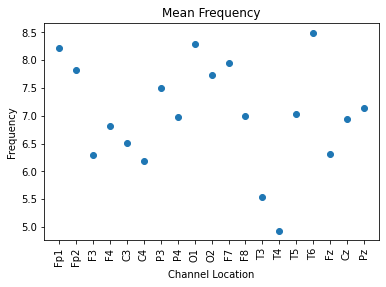

In [38]:
# Plot mean frequency and save to file
analyzer.plot_mean_frequency(output_file='mean_frequency_plot.png')

Extreme numbers plot saved to 'extreme_numbers_plot.pdf'


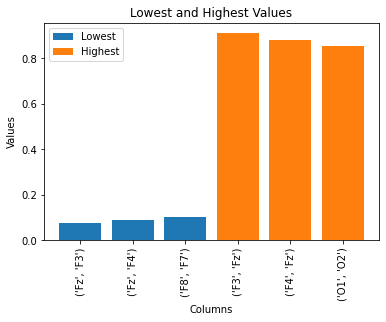

In [39]:
# Plot extreme numbers and save to file
analyzer.plot_extreme_numbers(output_file='extreme_numbers_plot.pdf')